# Extract text

**Imports**

In [1]:
import re
import json
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from pdfminer.layout import LAParams
import numpy as np
import networkx as nx
import pandas as pd
import locale
import tabula
import pdfplumber



In [2]:
from pdfminer.high_level import extract_text
def extract_text_from_pdf(pdf_path):
    laparams = LAParams()
    text = extract_text(pdf_path,laparams)
    return text.split("\f")

In [3]:
extract_text_from_pdf('CanadianTire.pdf')

['Canadian Tire Corporation Reports Third Quarter 2024 Results; Announces Annual \n\nDividend Increase for 15th Consecutive Year and Share Repurchase Intention \n\nToronto, November 7, 2024 – Canadian Tire Corporation, Limited (TSX:CTC, TSX: CTC.A) (CTC \nor the Company) today released its third quarter results for the period ended September 28, 2024.  \n\n•  Consolidated  comparable  sales1  trend  improved  compared  to  Q2  2024;  consolidated \n\ncomparable sales were down 1.5% compared to Q3 2023.  \n\n•  Diluted and Normalized Earnings Per Share1 (EPS) were $3.59, compared to $(1.19) in Q3 \n\n2023, and up 21.3% from $2.96 on a normalized basis. \n\n•  Annualized  dividend  increased  from  $7.00  to  $7.10  per  share,  alongside  an  intention  to \n\nrepurchase up to $200.0 million of Class A Non-Voting Shares in 2025.  \n\n“We delivered strong retail profitability for the third consecutive quarter and sales trends improved,” \n\nsaid  Greg  Hicks,  President  and  CEO,  Canad

## Extract text across pages

In [4]:

def normalize_text(text):
    return re.sub(r'\s+', ' ', text.strip()).lower()

def extract_text_between_words_across_pages(text_pages, start_word, end_word):
    # Normalize words
    start_word = normalize_text(start_word)
    end_word = normalize_text(end_word)
    extracted_texts = []
    combined_text = "\n".join([normalize_text(page) for page in text_pages])
    pattern = re.compile(re.escape(start_word) + '(.*?)' + re.escape(end_word), re.S)

    for match in pattern.finditer(combined_text):
        start_page, end_page = None, None
        start_index, end_index = match.start(), match.end()

        cumulative_length = 0
        for i, page in enumerate(text_pages):
            page_length = len(page)
            if start_page is None and start_index < cumulative_length + page_length:
                start_page = i + 1
            if end_page is None and end_index <= cumulative_length + page_length:
                end_page = i + 1
            cumulative_length += page_length + len("\n")
            if start_page is not None and end_page is not None:
                break

        extracted_texts.append({
            'start_page': start_page,
            'end_page': end_page,
            'start_word': start_word,
            'end_word': end_word,
            'extracted_text': match.group(1).strip()
        })
    return extracted_texts


Extract text by sections

In [5]:
start_end_pairs = [
    ('THIRD-QUARTER HIGHLIGHTS', 'products are set to roll out during 2025.'),
    ('CONSOLIDATED OVERVIEW','Company in the quarter.'),
    ('RETAIL SEGMENT OVERVIEW','impacted the Retail segment in the quarter.'),
    ('FINANCIAL SERVICES OVERVIEW','Services segment in the quarter.'),
    ('CT REIT OVERVIEW','November 5, 2024.'),
    ('CAPITAL ALLOCATION','million to $575 million.'),
    ('QUARTERLY DIVIDEND','for tax purposes.'),
    ('SHARE REPURCHASES','to regulatory approvals.'),
    ('1) NON-GAAP FINANCIAL MEASURES','Owned brand penetration'),
    ('FORWARD-LOOKING STATEMENTS', 'by applicable securities laws.'),
    ('CONFERENCE CALL','at this website for 12 months.'),
    ('ABOUT CANADIAN TIRE CORPORATION','visit Corp.CanadianTire.ca.'),
    ('FOR MORE INFORMATION','karen.keyes@cantire.com')
    # Add more pairs as needed
]


def process_files_in_folder(file_name, start_end_pairs):
    all_extracted_texts = []
    if file_name.endswith('.pdf'):
      text_pages = extract_text_from_pdf(file_name)
      for start_word, end_word in start_end_pairs:
        extracted_texts = extract_text_between_words_across_pages(text_pages, start_word, end_word)
        all_extracted_texts.extend(extracted_texts)

    return all_extracted_texts

all_extracted_texts = process_files_in_folder('CanadianTire.pdf', start_end_pairs)

## Cleansing/Preprocessing 

In [6]:
# Improved text normalization and cleaning
def advanced_preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Expand common contractions (e.g., "isn't" -> "is not")
    contractions_dict = {
        "isn't": "is not", "aren't": "are not", "can't": "cannot",
        "won't": "will not", "n't": " not", "'re": " are",
        "'s": " is", "'d": " would", "'ll": " will", "'t": " not",
        "'ve": " have", "'m": " am"
    }
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())))
    text = contractions_pattern.sub(lambda x: contractions_dict[x.group()], text)

    # Remove bullet points and special characters
    text = re.sub(r'[\u2022]', '', text)  # Remove specific bullet character
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove remaining non-alphanumeric characters
    
    # Tokenize the text into words
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Text summarizer
Summarize text by section
Lets Create a text summarizer using Cosine Distance

In [7]:
def generate_summary(article, top_n=5):
    stop_words = stopwords.words('english')
    summarize_text = []

    # Step 1 - Read text and split it into sentences
    sentences = [sent_tokenize(article)]
    sentences = [sent for sublist in sentences for sent in sublist]  # Flatten list of lists

    # Step 2 - Tokenize sentences for similarity calculation
    tokenized_sentences = [word_tokenize(sent) for sent in sentences]

    # Step 3 - Generate Similarity Matrix across sentences
    sentence_similarity_matrix = build_similarity_matrix(tokenized_sentences, stop_words)

    # Step 4 - Rank sentences in similarity matrix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_matrix)
    scores = nx.pagerank(sentence_similarity_graph)

    # Step 5 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    print("Indexes of top ranked_sentence order are ", ranked_sentence)
    
    for i in range(min(top_n, len(ranked_sentence))):
        summarize_text.append(ranked_sentence[i][1])

    # Return the summarized text
    print("Summarized Text: \n", ". ".join(summarize_text))
    return ". ".join(summarize_text)



# Function to build similarity matrix
def build_similarity_matrix(sentences, stop_words):
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2:  # Ignore same sentences
                continue
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)
    return similarity_matrix

# Function to compute sentence similarity
def sentence_similarity(sent1, sent2, stop_words=None):
    if stop_words is None:
        stop_words = []
    sent1 = [w.lower() for w in sent1 if w not in stop_words]
    sent2 = [w.lower() for w in sent2 if w not in stop_words]

    all_words = list(set(sent1 + sent2))
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)

    for w in sent1:
        vector1[all_words.index(w)] += 1
    for w in sent2:
        vector2[all_words.index(w)] += 1

    return 1 - cosine_distance(vector1, vector2)



## Saving and Structuring

In [8]:
def process_and_summarize_sections(extracted_sections, preprocess_func, summary_func, top_n_summary=1):
    processed_data = {
        'document_sections': []
    }

    for section in extracted_sections:
        
        # Preprocess the full text
        preprocessed_text = preprocess_func(section['extracted_text'])
        print(f"Summary for section starting with '{section['start_word']}' and ending with '{section['end_word']}':")
        # Generate summary
        summary = summary_func(preprocessed_text, top_n=top_n_summary)

        # Append to processed data
        processed_data['document_sections'].append({
            'start_word': section['start_word'],
            'end_word': section['end_word'],
            'preprocessed_text': preprocessed_text,
            'summary': summary,
            'full_text': section['extracted_text']
        })
    # Save the processed data to a JSON file
    with open('processed_document.json', 'w') as file:
        json.dump(processed_data, file, indent=4)

    return processed_data


In [9]:
processed_data = process_and_summarize_sections(all_extracted_texts, advanced_preprocess_text, generate_summary, top_n_summary=1)

Summary for section starting with 'third-quarter highlights' and ending with 'products are set to roll out during 2025.':
Indexes of top ranked_sentence order are  [(1.0, 'consolidated comparable sale 15 sportchek grew first quarter since q2 2023 partially offset decline canadian tire retail ctr mark ctr comparable sales1 22 compared q3 2023 customer continued prioritize essential category including automotive continued perform well strong quarter q3 2023 led growth automotive service sportchek comparable sales1 29 marking two consecutive quarter sportchek outperformed industry trend targeted promotional event improved customer experience continued focus contributed growth athletic footwear hockey category mark comparable sales1 23 led industrial wear decline partially offset growth men short tshirts childrens wear top performer result ongoing strategic rollout category select mark store increased loyalty engagement saw active registered loyalty member 4 member took advantage 11 offer 

# Visualisations 

In [10]:
import json
processed_data_string = json.dumps(processed_data, indent=4)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Uma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Uma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


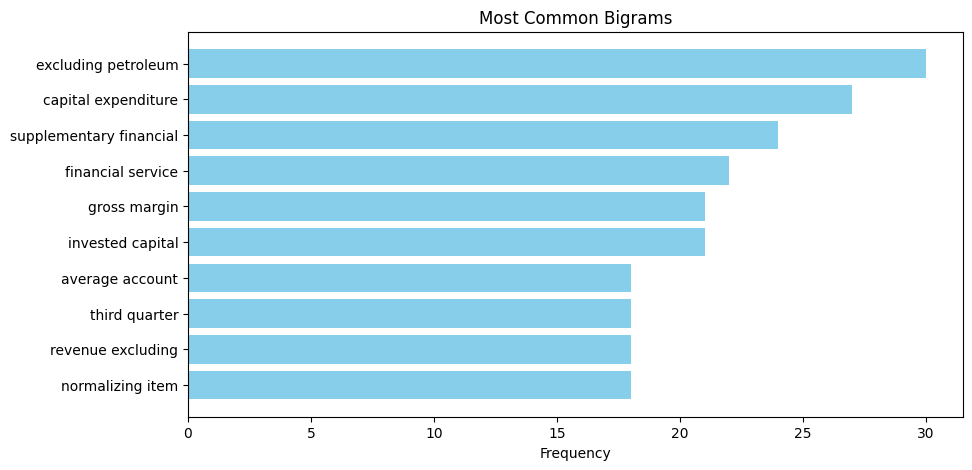

In [11]:
import nltk
from nltk.util import ngrams
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')

# Defining stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = {
    'million', 'retail', 'segment', 'normalized', 'consolidated',
    'asset', 'measure', 'investment', 'taxes', 'information','following','table','reconciles','ytd',
    'company', 'sale', 'customer', 'sales1', 'section', 'year', 'canadian',
       'income', 'q3', '2024', 'tax', '2023', 'ct', 'reit','could','cause','actual','c','le','operating'

}
stop_words.update(custom_stopwords)

# Preprocessing the text by removing stopwords
def preprocess_func(text):
    tokens = nltk.word_tokenize(text.lower())  # Tokenize and convert to lowercase
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # Remove stopwords
    return filtered_tokens

# Generating bigrams and trigrams from the tokens
def generate_ngrams(tokens, n=2):
    return list(ngrams(tokens, n))

processed_tokens = preprocess_func(processed_data_string)


bigrams = generate_ngrams(processed_tokens, n=2)
trigrams = generate_ngrams(processed_tokens, n=3)

# Counting the frequency of bigrams and trigrams
bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)


# Plotting bar chart for n-grams
def plot_ngram_counts(ngram_counts, title):
    common_ngram_counts = ngram_counts.most_common(10)  # Top 10 n-grams
    labels, values = zip(*common_ngram_counts)
    
    
    labels = [' '.join(label) for label in labels]

    plt.figure(figsize=(10, 5))
    plt.barh(labels, values, color='skyblue')
    plt.xlabel('Frequency')
    plt.title(title)
    plt.gca().invert_yaxis()  # To show the most frequent n-grams on top
    plt.show()


# Plot bar charts for the most common bigrams and trigrams
plot_ngram_counts(bigram_counts, "Most Common Bigrams")



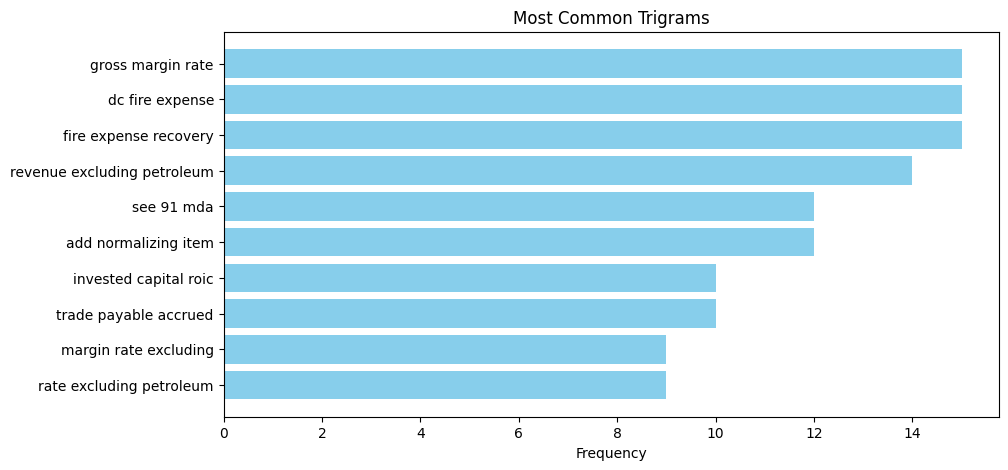

In [12]:
plot_ngram_counts(trigram_counts, "Most Common Trigrams")

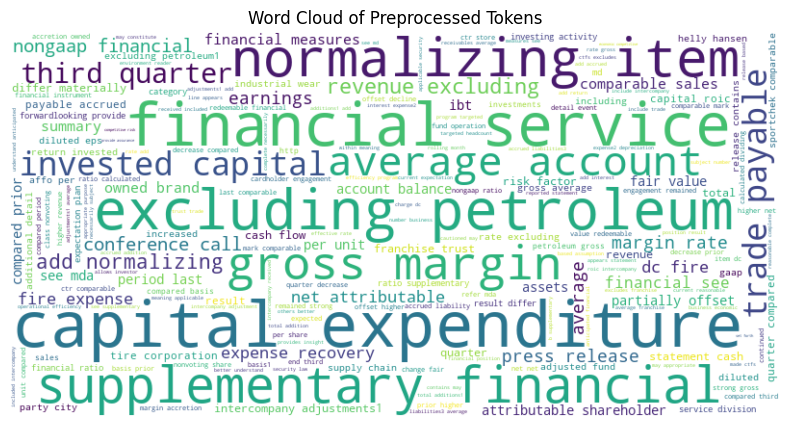

In [13]:
# Generate a word cloud from processed tokens
def generate_word_cloud(tokens, title):
    # Join tokens back into a single string for word cloud generation
    text = ' '.join(tokens)
    
    # Create word cloud
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        stopwords=stop_words,  # Use the stopwords defined earlier
        colormap='viridis'
    ).generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate and plot word cloud
generate_word_cloud(processed_tokens, "Word Cloud of Preprocessed Tokens")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Uma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


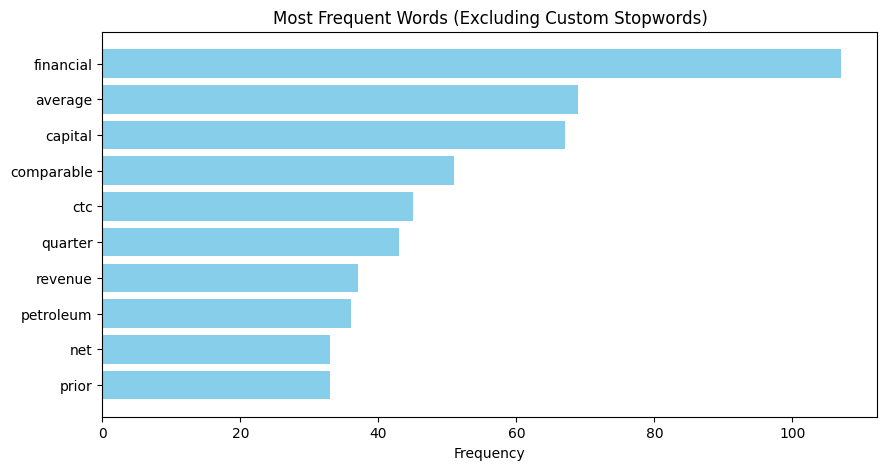

Most Frequent Words:
financial: 107
average: 69
capital: 67
comparable: 51
ctc: 45
quarter: 43
revenue: 37
petroleum: 36
net: 33
prior: 33


In [14]:
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import nltk

nltk.download('stopwords')

# Define default and custom stopwords
stop_words = set(stopwords.words('english'))
custom_stopwords = {
    'million', 'retail', 'segment', 'normalized', 'consolidated',
    'asset', 'measure', 'investment', 'taxes', 'information', 'following', 'table', 
    'reconciles', 'ytd', 'company', 'sale', 'customer', 'sales1', 'section', 
    'year', 'canadian', 'income', 'q3', '2024', 'tax', '2023', 'ct', 'reit', 
    'could', 'cause', 'actual', 'c', 'le', 'operating','compared','excluding','add','tire'
}
stop_words.update(custom_stopwords)



# Function to count and display the most frequent words
def display_most_frequent_words(tokens, top_n=10):
    # Count word frequencies
    # Function to preprocess the text by removing stopwords

    tokens = nltk.word_tokenize(processed_data_string.lower())  # Tokenize and convert to lowercase
    filtered_tokens = [word for word in tokens if word.isalnum() and word not in stop_words]  # Remove stopwords
    word_counts = Counter(filtered_tokens)
    
    # Get the top N most frequent words
    most_common_words = word_counts.most_common(top_n)
    
    # Separate words and their frequencies for plotting
    words, counts = zip(*most_common_words)
    
    # Plot the most frequent words
    plt.figure(figsize=(10, 5))
    plt.barh(words, counts, color='skyblue')
    plt.xlabel('Frequency')
    plt.title('Most Frequent Words (Excluding Custom Stopwords)')
    plt.gca().invert_yaxis()  # To show the most frequent words on top
    plt.show()

    # Print the most frequent words for reference
    print("Most Frequent Words:")
    for word, count in most_common_words:
        print(f"{word}: {count}")



# Display the most frequent words
display_most_frequent_words(processed_tokens, top_n=10)


# Scrapping tables

Tables on pages: 6,7,8,9 and 10 (3 tables on page 7)

In [15]:
# Function to set locale safely
def set_locale(locale_name):
    try:
        locale.setlocale(locale.LC_ALL, locale_name)
    except locale.Error:
        print(f"Locale {locale_name} not supported on this system. Using default locale.")
        locale.setlocale(locale.LC_ALL, '')

# Set the locale (adjust as necessary for your system)
set_locale('en_US.UTF-8')  # Common locale setting for Unix-like systems
locale._override_localeconv = {'n_sign_posn':1}

In [16]:
# Format as currency
def format_currency(value):
    if pd.isna(value):
        return ''
    return locale.currency(value, grouping=True).split('.')[0]

## Extract tables

In [17]:
# Path to the PDF file
pdf_path = 'CanadianTire.pdf'
table = tabula.read_pdf(pdf_path, pages=[6,7,8,9,10], multiple_tables=True)

Failed to import jpype dependencies. Fallback to subprocess.
No module named 'jpype'


## Separate and organize them

Tables on pages: 6,7,8,9 and 10 (3 tables on page 7)

### Table 1 - Page 6

In [18]:
table1 = table[0]
table1

,Net income,$,220.7 $,(27.8) $,540.2 $,141.9
0,Net income attributable to shareholders,NaN,200.6,(66.4),476.2,40.8
1,Add normalizing items:,NaN,NaN,NaN,NaN,NaN
2,DC fire expense (recovery),$,— $,(96.4) $,— $,8.4
3,GST/HST-related charge1,NaN,—,—,—,24.7
4,Change in fair value of redeemable financial i...,NaN,—,328.0,—,328.0
5,Normalized Net income,$,220.7 $,203.8 $,540.2 $,503.0
6,Normalized Net income attributable to sharehol...,$,200.6 $,165.2 $,476.2 $,396.9
7,Normalized Diluted EPS,$,3.59 $,2.96 $,8.54 $,7.0


we drop the extra column

In [19]:
table1.drop(columns='$', inplace=True)

All of the tables are omiting the column names and instead are using the first row as such. For this we create a function to add the names of the columns and use the first column as the index

In [20]:
def structure_table(table, new_columns):
    # Step 1: Move the current header to the first row
    table = table.rename(columns={i: col for i, col in enumerate(table.iloc[0])})
    table.loc[-1] = list(table.columns)  # Insert the header row as the first row
    table.index = table.index + 1       # Adjust the index
    table = table.sort_index()          # Re-sort by index

    # Step 2: Rename the columns
    table.columns = new_columns
    
    return table

In [21]:
new_columns = ['(C$ in millions)','Q3_2024', 'Q3_2023', 'YTD_Q3_2024', 'YTD_Q3_2023']
table1 = structure_table(table1, new_columns)
print("\nModified DataFrame:")
table1


Modified DataFrame:


,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Net income,220.7 $,(27.8) $,540.2 $,141.9
1,Net income attributable to shareholders,200.6,(66.4),476.2,40.8
2,Add normalizing items:,NaN,NaN,NaN,NaN
3,DC fire expense (recovery),— $,(96.4) $,— $,8.4
4,GST/HST-related charge1,—,—,—,24.7
5,Change in fair value of redeemable financial i...,—,328.0,—,328.0
6,Normalized Net income,220.7 $,203.8 $,540.2 $,503.0
7,Normalized Net income attributable to sharehol...,200.6 $,165.2 $,476.2 $,396.9
8,Normalized Diluted EPS,3.59 $,2.96 $,8.54 $,7.0


## Table 2-4: Pag 7

Tabula is not detecting the first table of the page 7, so it will be extracted using a different method

## First table

In [22]:
# Open the PDF file
with pdfplumber.open(pdf_path) as pdf:

    page = pdf.pages[6] #BMO Report has table on Page 4

    text = page.extract_text()

print(text)

lines = text.split('\n')

data = []
headers = None

for line in lines:
    columns = line.split()

    if '(C$ in millions)' in line:
        headers = columns
    elif any(char.isdigit() for char in line.split()[0]):
        data.append(columns)

The following table reconciles Consolidated Normalized Income Before Income Taxes to Income
Before Income Taxes:
YTD YTD
(C$ in millions) Q3 2024 Q3 2023 Q3 2024 Q3 2023
Income before income taxes $ 299.3 $ 69.3 $ 716.9 $ 309.8
Add normalizing items:
DC fire expense (recovery) — (131.0) — 11.3
GST/HST-related charge — — — 33.3
Change in fair value of redeemable financial instrument — 328.0 328.0
Normalized Income before income taxes $ 299.3 $ 266.3 $ 716.9 $ 682.4
The following table reconciles Retail Normalized Income Before Income Taxes to Income Before
Income Taxes:
YTD YTD
(C$ in millions) Q3 2024 Q3 2023 Q3 2024 Q3 2023
Income before income taxes $ 299.3 $ 69.3 $ 716.9 $ 309.8
Less: Other operating segments 134.5 (169.7) 381.4 64.5
Retail Income before income taxes $ 164.8 $ 239.0 $ 335.5 $ 245.3
Add normalizing items:
DC fire expense (recovery) — (131.0) — 11.3
Retail Normalized Income before income taxes $ 164.8 $ 108.0 $ 335.5 $ 256.6
The following table reconciles Financial Se

In [23]:
print(lines[3:10])
text = lines[3:10]

['(C$ in millions) Q3 2024 Q3 2023 Q3 2024 Q3 2023', 'Income before income taxes $ 299.3 $ 69.3 $ 716.9 $ 309.8', 'Add normalizing items:', 'DC fire expense (recovery) — (131.0) — 11.3', 'GST/HST-related charge — — — 33.3', 'Change in fair value of redeemable financial instrument — 328.0 328.0', 'Normalized Income before income taxes $ 299.3 $ 266.3 $ 716.9 $ 682.4']


In [24]:
table_data = []
# Regex to extract the description and four dollar values or placeholders
pattern = r"^(.*?)(?:\s+\$?\s*(-?[\d.]+|—)\s+\$?\s*(-?[\d.]+|—)\s+\$?\s*(-?[\d.]+|—)\s+\$?\s*(-?[\d.]+|—))?$"

# Process each line in the text
for line in text[1:]:  # Skip the first line (header)
    match = re.match(pattern, line)
    if match:
        description = match.group(1).strip()  # Extract description
        values = [match.group(i).strip() if match.group(i) else "-" for i in range(2, 6)]  # Extract values
        table_data.append([description] + values)

# Create a DataFrame with appropriate column names
table2 = pd.DataFrame(table_data, columns=new_columns)
table2

,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Income before income taxes,299.3,69.3,716.9,309.8
1,Add normalizing items:,-,-,-,-
2,DC fire expense (recovery) — (131.0) — 11.3,-,-,-,-
3,GST/HST-related charge,—,—,—,33.3
4,Change in fair value of redeemable financial i...,-,-,-,-
5,Normalized Income before income taxes,299.3,266.3,716.9,682.4


In [25]:
# Let's manually update the specific row 2
row_index = 2

# Manually split the data and assign values
table2.at[row_index, '(C$ in millions)'] = 'DC fire expense (recovery)'
table2.at[row_index, 'Q3_2024'] = '-'
table2.at[row_index, 'Q3_2023'] = '(131.0)'
table2.at[row_index, 'YTD_Q3_2024'] = '-'
table2.at[row_index, 'YTD_Q3_2023'] = '11.3'

# Let's manually update the specific row 2
row_index = 4

# Manually split the data and assign values
table2.at[row_index, '(C$ in millions)'] = 'DC fire expense (recovery)'
table2.at[row_index, 'Q3_2024'] = '-'
table2.at[row_index, 'Q3_2023'] = '328.0'
table2.at[row_index, 'YTD_Q3_2024'] = '-'
table2.at[row_index, 'YTD_Q3_2023'] = '328.0'

# Display the modified DataFrame
table2

,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Income before income taxes,299.3,69.3,716.9,309.8
1,Add normalizing items:,-,-,-,-
2,DC fire expense (recovery),-,(131.0),-,11.3
3,GST/HST-related charge,—,—,—,33.3
4,DC fire expense (recovery),-,328.0,-,328.0
5,Normalized Income before income taxes,299.3,266.3,716.9,682.4


### Tables 3-4: Page 7

In [26]:
table3 = table[1]
table3

,Income before income taxes,$,299.3 $,69.3 $,716.9 $,309.8
0,Less: Other operating segments,NaN,134.5,(169.7),381.4,64.5
1,Retail Income before income taxes,$,164.8 $,239.0 $,335.5 $,245.3
2,Add normalizing items:,NaN,NaN,NaN,NaN,NaN
3,DC fire expense (recovery),NaN,—,(131.0),—,11.3
4,Retail Normalized Income before income taxes,$,164.8 $,108.0 $,335.5 $,256.6


In [27]:
table3.drop(columns="$", inplace=True)
table3

,Income before income taxes,299.3 $,69.3 $,716.9 $,309.8
0,Less: Other operating segments,134.5,(169.7),381.4,64.5
1,Retail Income before income taxes,164.8 $,239.0 $,335.5 $,245.3
2,Add normalizing items:,NaN,NaN,NaN,NaN
3,DC fire expense (recovery),—,(131.0),—,11.3
4,Retail Normalized Income before income taxes,164.8 $,108.0 $,335.5 $,256.6


In [28]:
new_columns = ['(C$ in millions)','Q3_2024', 'Q3_2023', 'YTD_Q3_2024', 'YTD_Q3_2023']
table3 = structure_table(table3, new_columns)
print("\nModified DataFrame:")
table3


Modified DataFrame:


,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Income before income taxes,299.3 $,69.3 $,716.9 $,309.8
1,Less: Other operating segments,134.5,(169.7),381.4,64.5
2,Retail Income before income taxes,164.8 $,239.0 $,335.5 $,245.3
3,Add normalizing items:,NaN,NaN,NaN,NaN
4,DC fire expense (recovery),—,(131.0),—,11.3
5,Retail Normalized Income before income taxes,164.8 $,108.0 $,335.5 $,256.6


In [29]:
table4 = table[2]
table4

,Income before income taxes,$ 299.3,$ 69.3,Unnamed: 0,$ 716.9,$ 309.8
0,Less: Other operating segments,189.0,(56.4),NaN,422.4,10.0
1,Financial Services Income before income t...,$ 110.3,$ 125.7,NaN,$ 294.5,$ 299.8
2,Add normalizing items:,NaN,NaN,NaN,NaN,NaN
3,GST/HST-related charge,—,—,NaN,—,33.3
4,Financial Services Normalized Income befor...,$ 110.3,$ 125.7,NaN,$ 294.5,$ 333.1


In [30]:
table4.drop(columns="Unnamed: 0", inplace=True)
table4

,Income before income taxes,$ 299.3,$ 69.3,$ 716.9,$ 309.8
0,Less: Other operating segments,189.0,(56.4),422.4,10.0
1,Financial Services Income before income t...,$ 110.3,$ 125.7,$ 294.5,$ 299.8
2,Add normalizing items:,NaN,NaN,NaN,NaN
3,GST/HST-related charge,—,—,—,33.3
4,Financial Services Normalized Income befor...,$ 110.3,$ 125.7,$ 294.5,$ 333.1


In [31]:
new_columns = ['(C$ in millions)','Q3_2024', 'Q3_2023', 'YTD_Q3_2024', 'YTD_Q3_2023']
table4 = structure_table(table4, new_columns)
print("\nModified DataFrame:")
table4


Modified DataFrame:


,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Income before income taxes,$ 299.3,$ 69.3,$ 716.9,$ 309.8
1,Less: Other operating segments,189.0,(56.4),422.4,10.0
2,Financial Services Income before income t...,$ 110.3,$ 125.7,$ 294.5,$ 299.8
3,Add normalizing items:,NaN,NaN,NaN,NaN
4,GST/HST-related charge,—,—,—,33.3
5,Financial Services Normalized Income befor...,$ 110.3,$ 125.7,$ 294.5,$ 333.1


## Table 5: Pag 8

In [32]:
table5 = table[3]
table5

,Income before income taxes,$,299.3 $,69.3,$.1,716.9 $,309.8
0,Less: Other operating segments,NaN,204.8,58.0,NaN,418.0,118.6
1,CT REIT income before income taxes,$,94.5 $,11.3,$,29 8.9$,191.2
2,Add:,NaN,NaN,NaN,NaN,NaN,NaN
3,CT REIT fair value loss (gain) adjustment,NaN,(17.7),66.7,NaN,(64.3),39.3
4,CT REIT deferred taxes,NaN,(0.6),(0.2),NaN,0.2,0.7
5,CT REIT lease principal payments on right-of-u...,NaN,(0.2),(0.2),NaN,(0.6),(0.7)
6,CT REIT fair value of equity awards,NaN,1.9,(0.9),NaN,0.7,(1.1)
7,CT REIT internal leasing expense,NaN,0.2,0.4,NaN,0.8,0.8
8,CT REIT funds from operations,$,78.1 $,77.1,$,235.7 $,230.2
9,Less:,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
table5.drop(columns=["$.1", "$"], inplace=True)
table5

,Income before income taxes,299.3 $,69.3,716.9 $,309.8
0,Less: Other operating segments,204.8,58.0,418.0,118.6
1,CT REIT income before income taxes,94.5 $,11.3,29 8.9$,191.2
2,Add:,NaN,NaN,NaN,NaN
3,CT REIT fair value loss (gain) adjustment,(17.7),66.7,(64.3),39.3
4,CT REIT deferred taxes,(0.6),(0.2),0.2,0.7
5,CT REIT lease principal payments on right-of-u...,(0.2),(0.2),(0.6),(0.7)
6,CT REIT fair value of equity awards,1.9,(0.9),0.7,(1.1)
7,CT REIT internal leasing expense,0.2,0.4,0.8,0.8
8,CT REIT funds from operations,78.1 $,77.1,235.7 $,230.2
9,Less:,NaN,NaN,NaN,NaN


In [34]:
new_columns = ['(C$ in millions)','Q3_2024', 'Q3_2023', 'YTD_Q3_2024', 'YTD_Q3_2023']
table5 = structure_table(table5, new_columns)
print("\nModified DataFrame:")
table5


Modified DataFrame:


,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Income before income taxes,299.3 $,69.3,716.9 $,309.8
1,Less: Other operating segments,204.8,58.0,418.0,118.6
2,CT REIT income before income taxes,94.5 $,11.3,29 8.9$,191.2
3,Add:,NaN,NaN,NaN,NaN
4,CT REIT fair value loss (gain) adjustment,(17.7),66.7,(64.3),39.3
5,CT REIT deferred taxes,(0.6),(0.2),0.2,0.7
6,CT REIT lease principal payments on right-of-u...,(0.2),(0.2),(0.6),(0.7)
7,CT REIT fair value of equity awards,1.9,(0.9),0.7,(1.1)
8,CT REIT internal leasing expense,0.2,0.4,0.8,0.8
9,CT REIT funds from operations,78.1 $,77.1,235.7 $,230.2


## Table 6: Pag 9

In [35]:
table6 = tabula.read_pdf(pdf_path, pages=9, multiple_tables=False)

In [36]:
# Define the area manually for the part of the page that contains the table
table6 = tabula.read_pdf(pdf_path, pages=9, multiple_tables=False, stream=True)

table6 = table6[0]
table6


,(C$ in millions),Unnamed: 1,Q3 2024,Unnamed: 3,Q3 2023
0,Income before income taxes,$,979.8,$,"1,062.0"
1,Less: Other operating segments,NaN,482.6,NaN,174.3
2,Retail Income before income taxes,$,497.2,$,887.7
3,Add normalizing items:,NaN,NaN,NaN,NaN
4,Operational Efficiency program,NaN,—,NaN,19.5
5,Targeted headcount reduction-related charge,NaN,19.6,NaN,—
6,DC fire expense (recovery),NaN,—,NaN,11.3
7,Retail Normalized Income before income taxes,$,516.8,$,918.5
8,Less:,NaN,NaN,NaN,NaN
9,Retail intercompany adjustments1,NaN,216.7,NaN,213.7


In [37]:
table6.drop(columns=['Unnamed: 1','Unnamed: 3'], inplace=True)
table6

,(C$ in millions),Q3 2024,Q3 2023
0,Income before income taxes,979.8,"1,062.0"
1,Less: Other operating segments,482.6,174.3
2,Retail Income before income taxes,497.2,887.7
3,Add normalizing items:,NaN,NaN
4,Operational Efficiency program,—,19.5
5,Targeted headcount reduction-related charge,19.6,—
6,DC fire expense (recovery),—,11.3
7,Retail Normalized Income before income taxes,516.8,918.5
8,Less:,NaN,NaN
9,Retail intercompany adjustments1,216.7,213.7


## Table 7: Pag 10

In [38]:
table7 = table[5]
table7


,Total additions1,$,216.4,$.1,188.6,$.2,490.2 $,396.6
0,Add: Accrued additions,NaN,(21.3),NaN,(12.2),NaN,(32.6),39.2
1,Less: CT REIT acquisitions and developments,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,excluding vend-ins from CTC,NaN,68.0,NaN,21.3,NaN,82.0,42.7
3,Operating capital expenditures,$,127.1,$,155.1,$,375.6 $,393.1


In [39]:
table7.drop(columns=['$','$.1','$.2'], inplace=True)
table7

,Total additions1,216.4,188.6,490.2 $,396.6
0,Add: Accrued additions,(21.3),(12.2),(32.6),39.2
1,Less: CT REIT acquisitions and developments,NaN,NaN,NaN,NaN
2,excluding vend-ins from CTC,68.0,21.3,82.0,42.7
3,Operating capital expenditures,127.1,155.1,375.6 $,393.1


In [40]:
new_columns = ['(C$ in millions)','Q3_2024', 'Q3_2023', 'YTD_Q3_2024', 'YTD_Q3_2023']
table7 = structure_table(table7, new_columns)
print("\nModified DataFrame:")
table7


Modified DataFrame:


,(C$ in millions),Q3_2024,Q3_2023,YTD_Q3_2024,YTD_Q3_2023
0,Total additions1,216.4,188.6,490.2 $,396.6
1,Add: Accrued additions,(21.3),(12.2),(32.6),39.2
2,Less: CT REIT acquisitions and developments,NaN,NaN,NaN,NaN
3,excluding vend-ins from CTC,68.0,21.3,82.0,42.7
4,Operating capital expenditures,127.1,155.1,375.6 $,393.1


In [53]:
table7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   (C$ in millions)  5 non-null      object
 1   Q3_2024           4 non-null      object
 2   Q3_2023           4 non-null      object
 3   YTD_Q3_2024       4 non-null      object
 4   YTD_Q3_2023       4 non-null      object
dtypes: object(5)
memory usage: 240.0+ bytes


# Cleaning tables

In [41]:
def clean_tables(numeric_columns, table):
    table_df = table.copy()

    for col in numeric_columns:
        # Replace unwanted characters to prepare for numeric conversion
        table_df[col] = table_df[col].astype(str).str.replace('$', '', regex=False)
        table_df[col] = table_df[col].str.replace(',', '', regex=False)
        table_df[col] = table_df[col].str.replace('(', '-', regex=False)
        table_df[col] = table_df[col].str.replace(')', '', regex=False)

        # Convert all values to float, coercing errors into NaN
        table_df[col] = pd.to_numeric(table_df[col], errors='coerce')

        # Format numeric values
        table_df[col] = table_df[col].apply(
            lambda x: format_currency(x) if pd.notna(x) else '-'
        )

    return table_df


In [42]:
tables = [table1, table2, table3, table4, table5, table6, table7]

In [43]:
cleaned_tables = []

for table in tables:
    cleaned_tables.append(clean_tables(table.columns[1:], table))

In [61]:
import pandas as pd
import numpy as np

def convert_to_numeric(table7, columns=None):
    """
    Converts specified columns or all object columns in a DataFrame to numeric.
    Non-convertible values (e.g., '-', empty strings) are replaced with NaN.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to process.
    - columns (list, optional): List of columns to convert. If None, all object columns are processed.
    
    Returns:
    - pd.DataFrame: A DataFrame with the specified columns converted to numeric.
    """
    # If no specific columns are provided, select all object columns
    if columns is None:
        columns = table7.select_dtypes(include=['object']).columns

    for col in columns:
        # Remove non-numeric characters and handle invalid values
        table7[col] = (
            table7[col]
            .astype(str)  # Ensure column is treated as strings
            .str.replace(r'[^\d.-]', '', regex=True)  # Remove non-numeric characters except '-' and '.'
            .replace(['', '-', 'NaN'], np.nan)  # Replace invalid values with NaN
            .astype(float)  # Convert to float
        )
    
    return table7
table7=convert_to_numeric(table7)

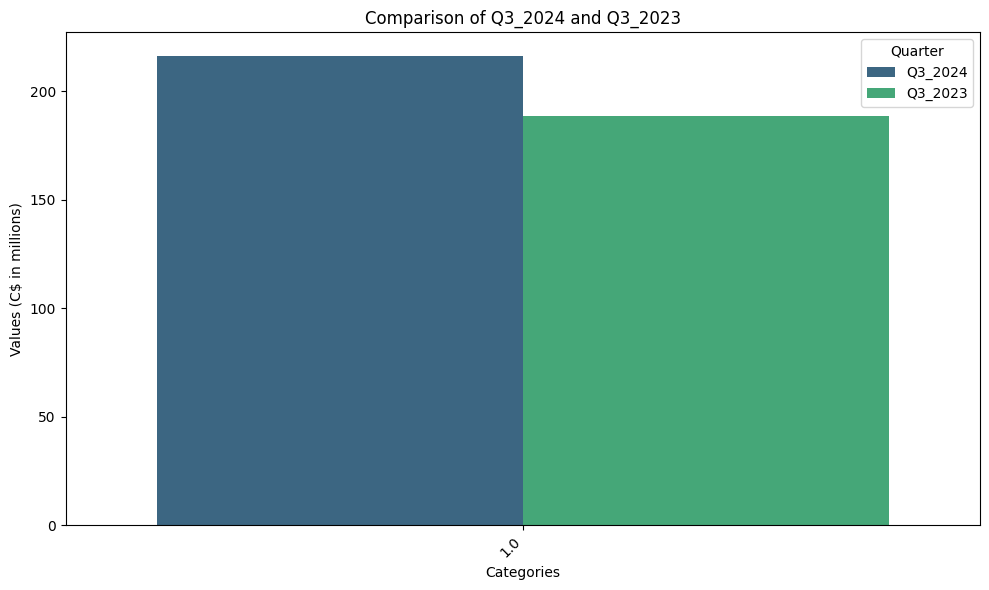

In [64]:
#Bar Plot: Comparing Q3_2024 and Q3_2023
import seaborn as sns
df_melted = table7.melt(
    id_vars=["(C$ in millions)"],
    value_vars=["Q3_2024", "Q3_2023"],
    var_name="Quarter",
    value_name="Values"
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="(C$ in millions)", y="Values", hue="Quarter", data=df_melted, palette="viridis"
)
plt.title("Comparison of Q3_2024 and Q3_2023")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Values (C$ in millions)")
plt.xlabel("Categories")
plt.tight_layout()
plt.show()



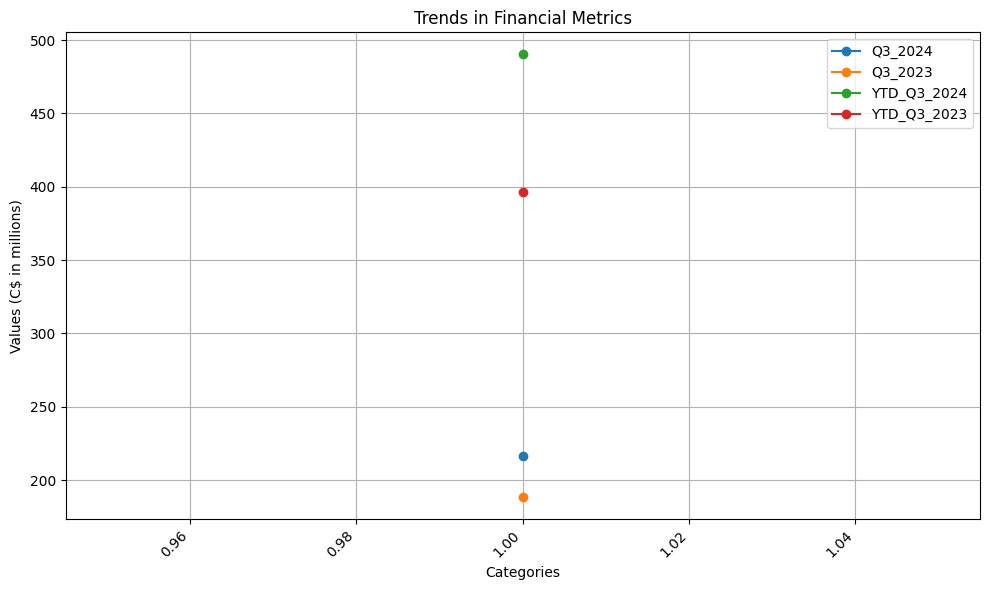

In [65]:

# Line Plot: Trends across different quarters and YTD
plt.figure(figsize=(10, 6))
for col in ["Q3_2024", "Q3_2023", "YTD_Q3_2024", "YTD_Q3_2023"]:
    plt.plot(table7["(C$ in millions)"], table7[col], marker='o', label=col)

plt.title("Trends in Financial Metrics")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Values (C$ in millions)")
plt.xlabel("Categories")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


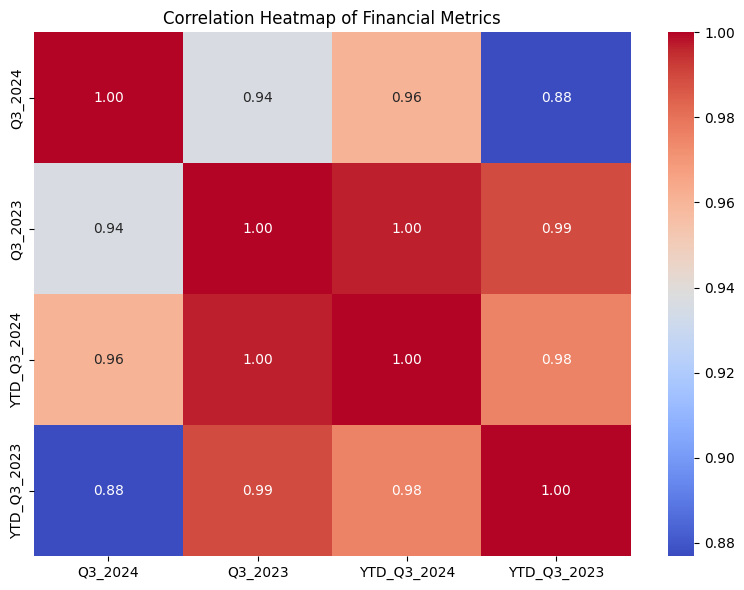

In [66]:

# Heatmap: Correlation of financial metrics
numeric_table7 = table7.drop(["(C$ in millions)"], axis=1).apply(pd.to_numeric, errors="coerce")
correlation = numeric_table7.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Financial Metrics")
plt.tight_layout()
plt.show()

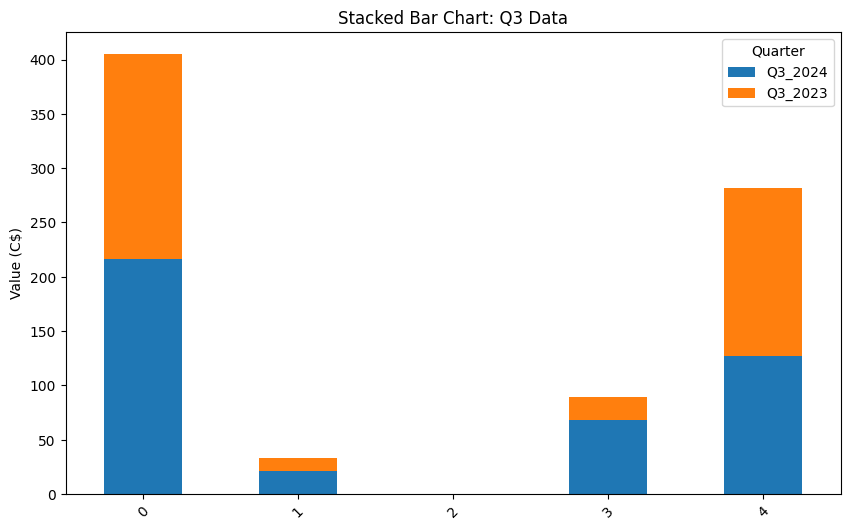

In [67]:
table7[["Q3_2024", "Q3_2023"]].plot(kind="bar", stacked=True, figsize=(10, 6), color=["#1f77b4", "#ff7f0e"])
plt.title("Stacked Bar Chart: Q3 Data")
plt.ylabel("Value (C$)")
plt.xticks(rotation=45)
plt.legend(title="Quarter")
plt.show()


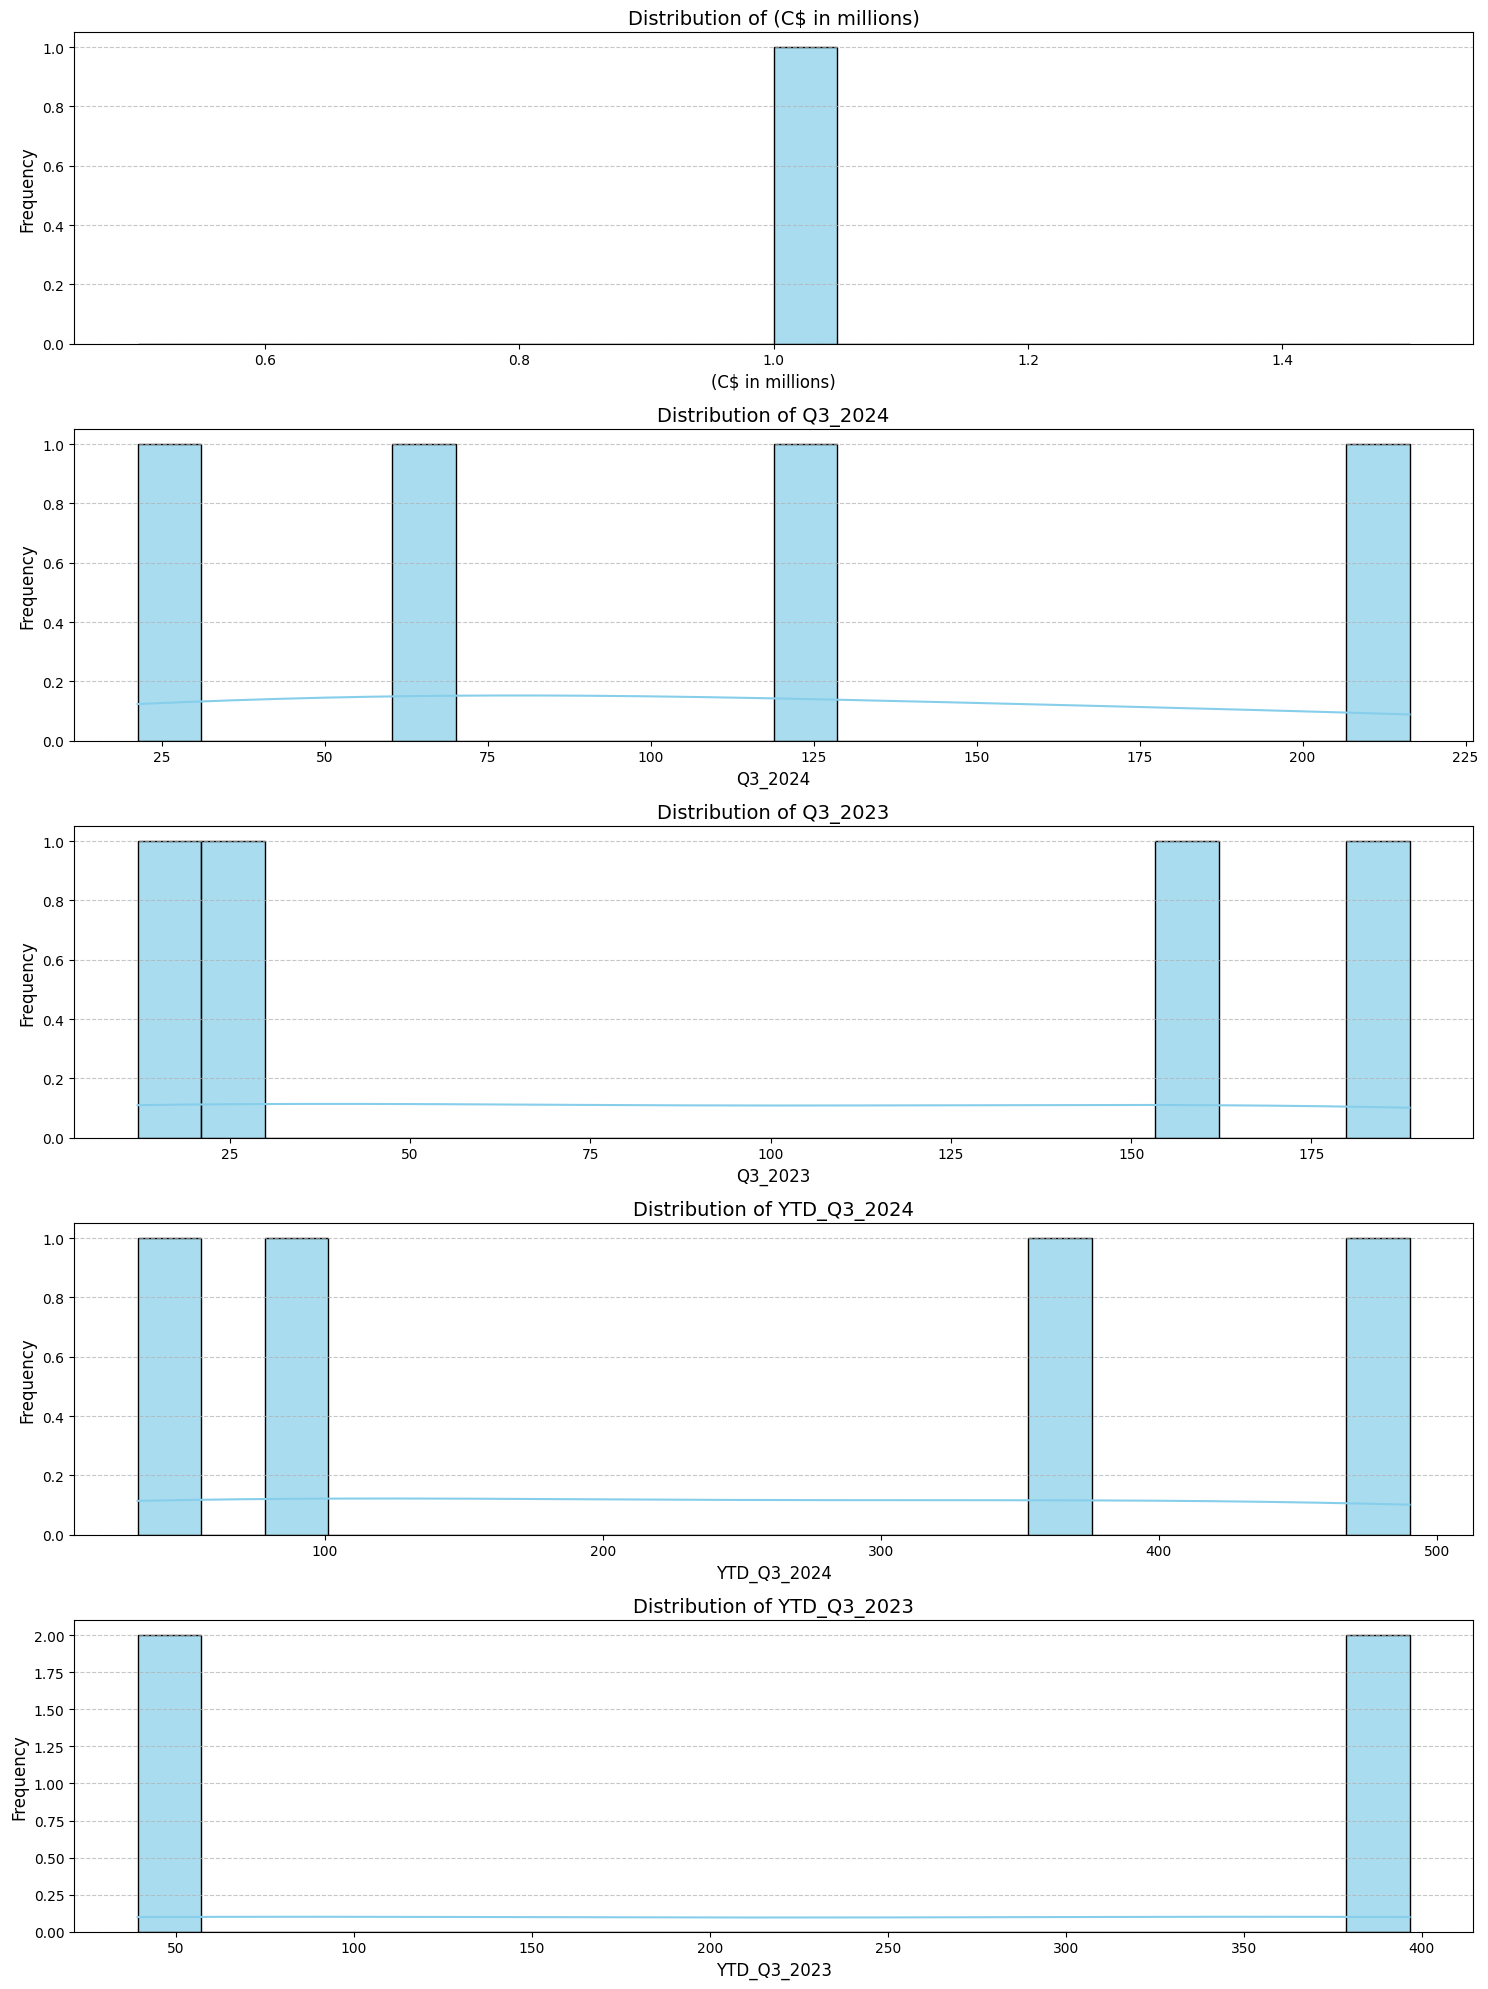

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_distribution(df):
    # Iterate through each numeric column in the DataFrame
    numeric_cols = df.select_dtypes(include=["number"]).columns
    
    # Set up the layout for subplots
    num_cols = len(numeric_cols)
    plt.figure(figsize=(15, num_cols * 4))
    
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(num_cols, 1, i)
        sns.histplot(df[col], kde=True, bins=20, color="skyblue", alpha=0.7)
        plt.title(f"Distribution of {col}", fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.grid(axis="y", linestyle="--", alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Call the function on your DataFrame
visualize_distribution(table7)
